In [ ]:
"""
This python notebook illustrates how a 3 variable optimization problem using RL
"""

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple, deque
import random

In [2]:
class DQN(nn.Module):
    def __init__(self, obs, act):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, act)
        )
    def forward(self, x):
        return self.net(x)

In [3]:
SEED = 42 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# For CUDA: torch.cuda.manual_seed_all(SEED)

print(f"Random seeds set to {SEED}")

Random seeds set to 42


In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer:
    def __init__(self, cap=10000):
        self.buffer = deque([], maxlen=cap)
    
    def push(self, *args):
        self.buffer.append(Transition(*args))
    
    def sample(self, batch_size):
       return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

In [5]:
# Objective: max(z) = 60x1 + 30x2 + 20x3
def objective_3d(x1, x2, x3):
    return 60 * x1 + 30 * x2 + 20 * x3

# Constraint 1: 8x1 + 6x2 + x3 <= 48
def constraint1_3d(x1, x2, x3):
    return 8 * x1 + 6 * x2 + x3 - 48

# Constraint 2: 4x1 + 2x2 + 1.5x3 <= 20
def constraint2_3d(x1, x2, x3):
    return 4 * x1 + 2 * x2 + 1.5 * x3 - 20

# Constraint 3: 2x1 + 1.5x2 + 0.5x3 <= 8
def constraint3_3d(x1, x2, x3):
    return 2 * x1 + 1.5 * x2 + 0.5 * x3 - 8

# Constraint 4: x2 <= 5
def constraint4_3d(x1, x2, x3):
    return x2 - 5

In [ ]:
class LinearOptimizationEnv:
    """
    3D environment for the optimization problem.
    State: [x1, x2, x3], Action space: 6 (increase/decrease each variable)
    """
    def __init__(self, max_steps=750):
        self.step_size = 1
        self.max_steps = max_steps
        self.penalty = 100.0
        
        self.x1_bounds = (0, 10)
        self.x2_bounds = (0, 5)
        self.x3_bounds = (0, 20)
        
        self.action_space_size = 6
        self.state_space_size = 3

        self.x1, self.x2, self.x3 = 0.0, 0.0, 0.0
        self.current_step = 0

    def _get_state(self):
        """Return current state as a numpy array."""
        return np.array([self.x1, self.x2, self.x3], dtype=np.float32)

    def _calculate_violation(self, x1, x2, x3):
        """Calculate the sum of all constraint violations."""
        c1 = max(0, constraint1_3d(x1, x2, x3))
        c2 = max(0, constraint2_3d(x1, x2, x3))
        c3 = max(0, constraint3_3d(x1, x2, x3))
        c4 = max(0, constraint4_3d(x1, x2, x3))
        return c1 + c2 + c3 + c4

    def reset(self, seed=None, options=None):
        """Reset environment to a known feasible starting point."""
        self.current_step = 0
        self.x1, self.x2, self.x3 = 1.0, 1.0, 1.0
        normalized_state = self._get_state() / np.array([10, 5, 20], dtype=np.float32)
        return normalized_state, {}

    def step(self, action):
        """Execute one time step with reward shaping."""
        self.current_step += 1
        prev_z = objective_3d(self.x1, self.x2, self.x3)

        if action == 0: self.x1 += self.step_size
        elif action == 1: self.x1 -= self.step_size
        elif action == 2: self.x2 += self.step_size
        elif action == 3: self.x2 -= self.step_size
        elif action == 4: self.x3 += self.step_size
        elif action == 5: self.x3 -= self.step_size

        # Clip state to bounds
        self.x1 = np.clip(self.x1, self.x1_bounds[0], self.x1_bounds[1])
        self.x2 = np.clip(self.x2, self.x2_bounds[0], self.x2_bounds[1])
        self.x3 = np.clip(self.x3, self.x3_bounds[0], self.x3_bounds[1])

        current_z = objective_3d(self.x1, self.x2, self.x3)
        violation = self._calculate_violation(self.x1, self.x2, self.x3)

        done = False
        reward = 0.0
        
        if violation > 0:
            reward = -self.penalty
        else:
            reward = current_z - prev_z
            if current_z >= 279.9:
                reward += 280.0
                done = True
        
        if self.current_step >= self.max_steps:
            done = True

        info = {'objective': current_z, 'violation': violation, 'x1': self.x1, 'x2': self.x2, 'x3': self.x3}
        normalized_state = self._get_state() / np.array([10, 5, 20], dtype=np.float32)
        
        return normalized_state, reward, done, info

In [ ]:
def train_dqn(episodes=2000):
    """
    Train DQN for the 3-variable LinearOptimizationEnv.
    """
    GAMMA = 0.99
    TAU = 0.01
    EPSILON_START = 1.0
    EPSILON_END = 0.001
    EPSILON_DECAY = 30000 
    BATCH_SIZE = 128
    LR = 5e-4
    REPLAY_BUFFER_CAP = 50000

    # Initialize the 3D environment and networks
    env = LinearOptimizationEnv(max_steps=500)
    state_size = env.state_space_size
    action_size = env.action_space_size
    replay_buffer = ReplayBuffer(REPLAY_BUFFER_CAP)

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    policy_net = DQN(state_size, action_size).to(device)
    target_net = DQN(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

    # Logging lists
    all_rewards = []
    final_states_info = []
    avg_violations = []
    avg_objectives = []
    steps_done = 0

    for episode in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_violations = []
        episode_objectives = []

        for t in range(env.max_steps):
            steps_done += 1
            epsilon = EPSILON_END + (EPSILON_START - EPSILON_END) * np.exp(-steps_done / EPSILON_DECAY)
            
            if random.random() < epsilon:
                action = random.randrange(action_size)
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                    action = policy_net(state_tensor).argmax().item()
            
            next_state, reward, done, info = env.step(action)
            replay_buffer.push(state, action, next_state, reward)
            state = next_state
            
            episode_reward += reward
            episode_violations.append(info['violation'])
            episode_objectives.append(info['objective'])
            
            if len(replay_buffer) >= BATCH_SIZE:
                transitions = replay_buffer.sample(BATCH_SIZE)
                batch = Transition(*zip(*transitions))
                
                states_b = torch.FloatTensor(np.array(batch.state)).to(device)
                actions_b = torch.LongTensor(batch.action).unsqueeze(1).to(device)
                rewards_b = torch.FloatTensor(batch.reward).to(device)
                next_states_b = torch.FloatTensor(np.array(batch.next_state)).to(device)
                
                q_values = policy_net(states_b).gather(1, actions_b).squeeze(1)
                next_q_values = target_net(next_states_b).max(1)[0]
                target_q = rewards_b + (GAMMA * next_q_values)
                
                loss = nn.MSELoss()(q_values, target_q.detach())
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                optimizer.step()
            
            if done:
                break
        
        with torch.no_grad():
            for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
                target_param.data.copy_(TAU * policy_param.data + (1.0 - TAU) * target_param.data)
        
        all_rewards.append(episode_reward)
        final_states_info.append(info)
        avg_violations.append(np.mean(episode_violations))
        avg_objectives.append(np.mean(episode_objectives))
        
        if episode % 100 == 0:
            final_x1 = info['x1']
            final_x2 = info['x2']
            final_x3 = info['x3']
            print(f"Episode {episode} | Avg Reward: {np.mean(all_rewards[-100:]):.2f} | Epsilon: {epsilon:.3f} | "
                  f"Final State: ({final_x1:.2f}, {final_x2:.2f}, {final_x3:.2f}) | "
                  f"Avg Objective: {np.mean(avg_objectives[-100:]):.2f} | "
                  f"Avg Violation: {np.mean(avg_violations[-100:]):.2f}")
    
    return all_rewards, final_states_info, avg_violations, avg_objectives

In [9]:
a, b, c, d = train_dqn()
avg_violations = c
avg_objectives = d
final_states = b

Episode 0 | Avg Reward: -28210.00 | Epsilon: 0.983 | Final State: (3.00, 0.00, 4.00) | Avg Objective: 409.78 | Avg Violation: 37.36
Episode 100 | Avg Reward: -12311.50 | Epsilon: 0.486 | Final State: (1.00, 0.00, 12.00) | Avg Objective: 291.00 | Avg Violation: 8.54
Episode 200 | Avg Reward: -4891.50 | Epsilon: 0.154 | Final State: (0.00, 0.00, 12.00) | Avg Objective: 243.57 | Avg Violation: 0.43
Episode 300 | Avg Reward: 201.50 | Epsilon: 0.131 | Final State: (0.00, 1.00, 11.00) | Avg Objective: 225.20 | Avg Violation: 0.04
Episode 400 | Avg Reward: 305.50 | Epsilon: 0.117 | Final State: (2.00, 0.00, 8.00) | Avg Objective: 218.92 | Avg Violation: 0.04
Episode 500 | Avg Reward: 249.30 | Epsilon: 0.102 | Final State: (2.00, 0.00, 8.00) | Avg Objective: 217.08 | Avg Violation: 0.05
Episode 600 | Avg Reward: 273.90 | Epsilon: 0.092 | Final State: (2.00, 0.00, 8.00) | Avg Objective: 215.81 | Avg Violation: 0.03
Episode 700 | Avg Reward: 414.70 | Epsilon: 0.089 | Final State: (2.00, 0.00, 8.

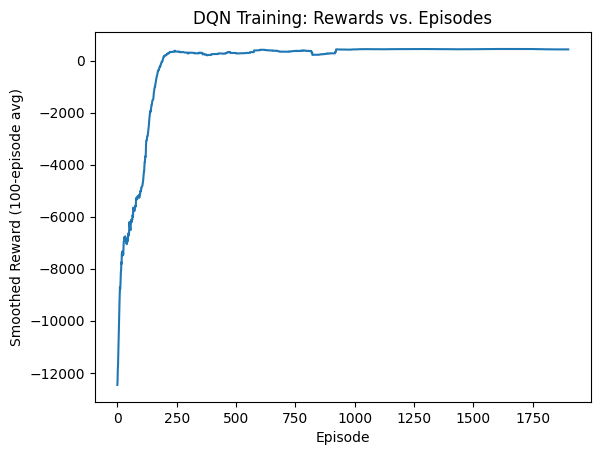

[np.float64(-28210.0), np.float64(-43830.0), np.float64(-22020.0), np.float64(-41960.0), np.float64(-43710.0), np.float64(-44370.0), np.float64(-45750.0), np.float64(-41800.0), np.float64(-43030.0), np.float64(-46700.0), np.float64(-41590.0), np.float64(-1670.0), np.float64(-13650.0), np.float64(-41750.0), np.float64(-48480.0), np.float64(-6410.0), np.float64(-41030.0), np.float64(-3790.0), np.float64(-41570.0), np.float64(-13070.0), np.float64(-41620.0), np.float64(-320.0), np.float64(-10880.0), np.float64(450.0), np.float64(-2490.0), np.float64(-35110.0), np.float64(-20230.0), np.float64(-2130.0), np.float64(-9920.0), np.float64(-21190.0), np.float64(-2530.0), np.float64(-2920.0), np.float64(-22680.0), np.float64(-3790.0), np.float64(-10250.0), np.float64(170.0), np.float64(-2710.0), np.float64(-5470.0), np.float64(-2100.0), np.float64(320.0), np.float64(-5600.0), np.float64(-24320.0), np.float64(-1810.0), np.float64(-2680.0), np.float64(-17130.0), np.float64(-18300.0), np.float64(-2

In [ ]:
all_rewards = a
smoothed_rewards = np.convolve(all_rewards, np.ones(100)/100, mode='valid')
plt.plot(smoothed_rewards)
plt.xlabel('Episode')
plt.ylabel('Smoothed Reward (100-episode avg)')
plt.title('DQN Training: Rewards vs. Episodes')
plt.show()

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.convolve(avg_violations, np.ones(100)/100, mode='valid'))
plt.xlabel('Episode')
plt.ylabel('Avg Violation')
plt.title('Constraint Violations vs. Episodes')
plt.subplot(1, 2, 2)
plt.plot(np.convolve(avg_objectives, np.ones(100)/100, mode='valid'))
plt.xlabel('Episode')
plt.ylabel('Avg Objective (z)')
plt.title('Objective Value vs. Episodes')
plt.tight_layout()
plt.show()

In [ ]:
l=[]
for i in final_states:
    l.append([float(i['x1']), float(i['x2']), float(i['x3'])])
print(l)

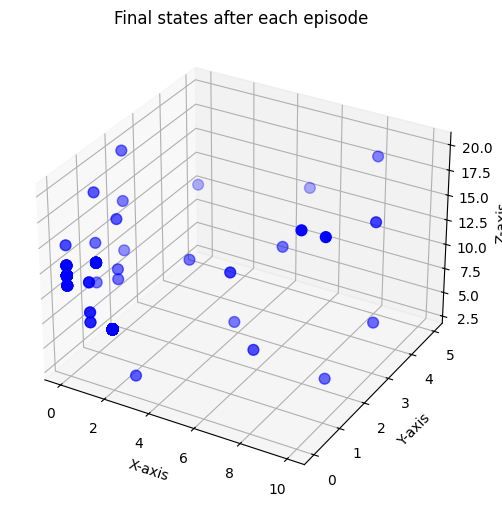

2000


In [ ]:
def plot_points_3d(points):
    if not points:
        print("No points to plot.")
        return
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    zs = [p[2] for p in points]
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(xs, ys, zs, c='blue', marker='o', s=60)

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.set_title("Final states after each episode")
    
    plt.show()
plot_points_3d(l)
print(len(l))